In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 1506 files belonging to 3 classes.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import json

# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/kaggle/input/500-plant/500_plant",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

# Function to partition dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Optimize datasets
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model definitions
def cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    return model

def resnet50_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(3, activation='softmax')
    ])
    return model

def efficientnet_model():
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(3, activation='softmax')
    ])
    return model

def vgg16_model():
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(3, activation='softmax')
    ])
    return model

def mobilenet_model():
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(3, activation='softmax')
    ])
    return model

# Dictionary of models
models = {
    "CNN": cnn_model(),
    "ResNet50": resnet50_model(),
    "EfficientNetB0": efficientnet_model(),
    "VGG16": vgg16_model(),
    "MobileNetV2": mobilenet_model()
}

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=5,          # number of epochs to wait for improvement
    restore_best_weights=True,  # restore the best weights once training is stopped
    verbose=1
)

# Compile and train each model, then evaluate on the test set
results = {}
for model_name, model in models.items():
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f"Training {model_name}...")
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[early_stopping]  # Include EarlyStopping
    )
    
    test_loss, test_accuracy = model.evaluate(test_ds)
    results[model_name] = {'Test Accuracy': test_accuracy, 'Test Loss': test_loss}
    print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# Save results as a JSON file for easy comparison
with open("model_comparison_results.json", "w") as f:
    json.dump(results, f)


Found 1506 files belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/tmp/ipykernel_30/4284764050.py:88: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training CNN...
Epoch 1/50


I0000 00:00:1729823684.980563     104 service.cc:145] XLA service 0x7dde18004630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729823684.980624     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729823684.980631     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/38 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3976 - loss: 2079.8376

I0000 00:00:1729823690.443287     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/38 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.3595 - loss: 3039.1990

I0000 00:00:1729823692.907486     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 8 bytes spill stores, 8 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - accuracy: 0.3979 - loss: 1757.4958 - val_accuracy: 0.7143 - val_loss: 0.6647
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7932 - loss: 0.6063 - val_accuracy: 0.9184 - val_loss: 0.3377
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9319 - loss: 0.1948 - val_accuracy: 0.9388 - val_loss: 0.3280
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9774 - loss: 0.0963 - val_accuracy: 0.9388 - val_loss: 0.4916
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9940 - loss: 0.0292 - val_accuracy: 0.9490 - val_loss: 0.4188
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9941 - loss: 0.0502 - val_accuracy: 0.9184 - val_loss: 0.3971
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9758 - loss: 0.0985 - val_accuracy: 0.9286 - val_loss: 0.6428
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9866 - loss: 0.0827 - val_accuracy: 0.9286 - val_los

I0000 00:00:1729824830.668208     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 16 bytes spill stores, 16 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 637ms/step - accuracy: 0.8869 - loss: 0.3262 - val_accuracy: 0.4082 - val_loss: 21.2508
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9762 - loss: 0.0988 - val_accuracy: 0.2959 - val_loss: 47.1627
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9879 - loss: 0.0431 - val_accuracy: 0.5918 - val_loss: 20.0502
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9947 - loss: 0.0163 - val_accuracy: 0.3367 - val_loss: 21.7513
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9926 - loss: 0.0328 - val_accuracy: 0.4490 - val_loss: 23.0228
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3958 - loss: 20.6431
MobileNetV2 - Test Accuracy: 0.3958, Test Loss: 20.0780


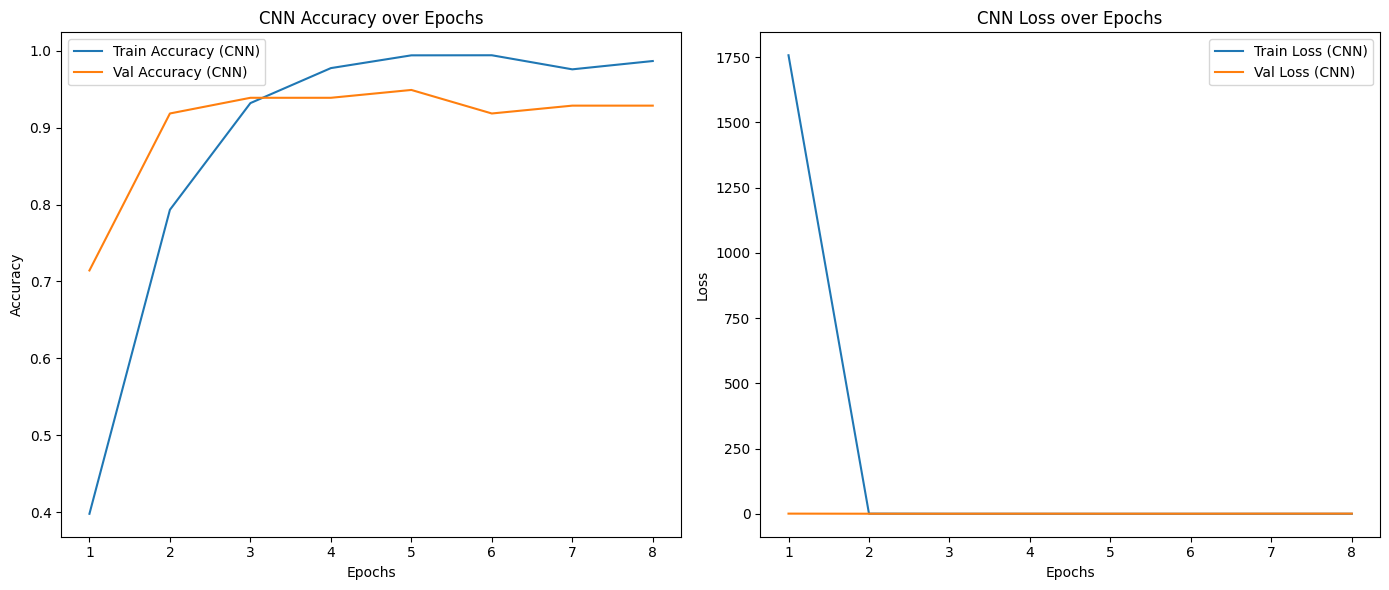

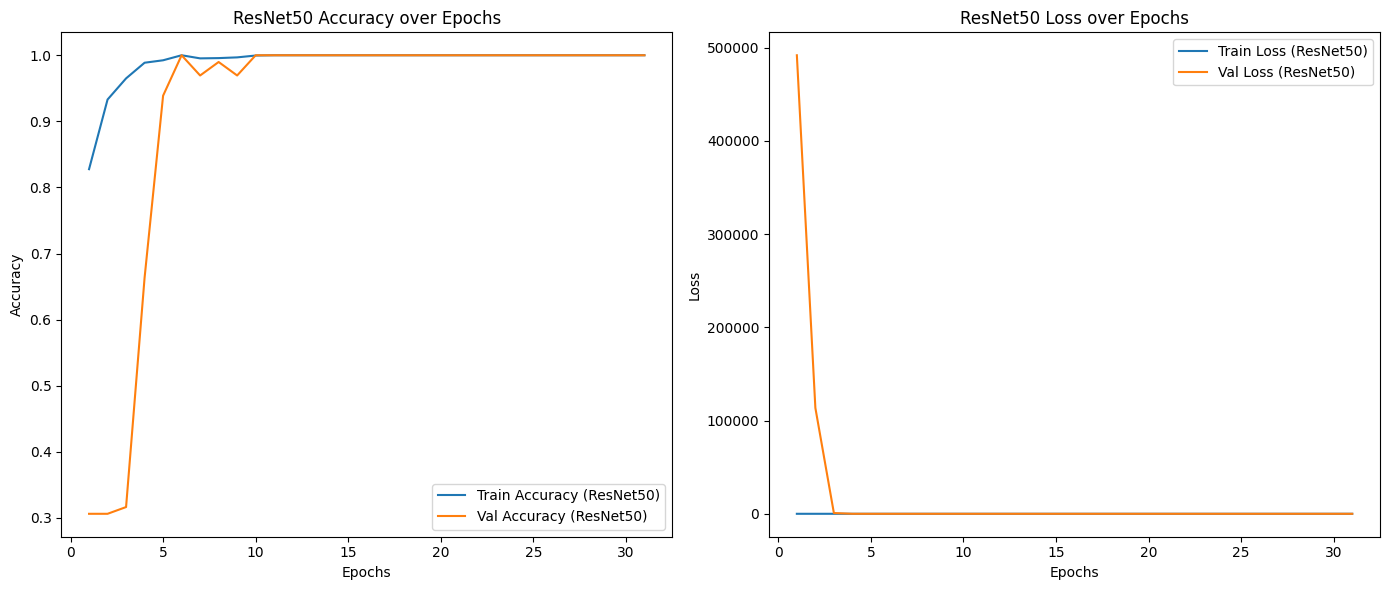

In [3]:
import matplotlib.pyplot as plt

# Data from training output for CNN and ResNet50
epochs_cnn = list(range(1, 9))
train_accuracy_cnn = [0.3979, 0.7932, 0.9319, 0.9774, 0.9940, 0.9941, 0.9758, 0.9866]
val_accuracy_cnn = [0.7143, 0.9184, 0.9388, 0.9388, 0.9490, 0.9184, 0.9286, 0.9286]
train_loss_cnn = [1757.4958, 0.6063, 0.1948, 0.0963, 0.0292, 0.0502, 0.0985, 0.0827]
val_loss_cnn = [0.6647, 0.3377, 0.3280, 0.4916, 0.4188, 0.3971, 0.6428, 0.6992]

epochs_resnet = list(range(1, 32))
train_accuracy_resnet = [0.8276, 0.9330, 0.9650, 0.9887, 0.9924, 1.0000, 0.9953, 0.9957, 0.9968, 0.9996, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
val_accuracy_resnet = [0.3061, 0.3061, 0.3163, 0.6633, 0.9388, 1.0000, 0.9694, 0.9898, 0.9694, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]
train_loss_resnet = [0.5120, 0.2412, 0.1016, 0.0460, 0.0389, 0.0059, 0.0120, 0.0134, 0.0082, 0.0040, 0.00063745, 0.00031854, 0.00025537, 0.00016728, 0.00016048, 0.00010966, 0.00012275, 0.00010001, 0.000093315, 0.000090158, 0.000074789, 0.000071226, 0.000065009, 0.000062164, 0.000061698, 0.000051306, 0.000040284, 0.000041858, 0.000033728, 0.000033792, 0.000031785]
val_loss_resnet = [491907.2188, 113566.3672, 810.2739, 10.4390, 0.1793, 0.0047, 0.0410, 0.0332, 0.0830, 0.0019, 0.00064042, 0.00031724, 0.00016817, 0.00011892, 0.000063657, 0.000046274, 0.000037037, 0.000029924, 0.000025016, 0.000022916, 0.000020096, 0.00001835, 0.00001693, 0.000015702, 0.000014532, 0.000013538, 0.000012713, 0.000011914, 0.00001109, 0.000010378, 0.000009531]

# Plotting CNN accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, train_accuracy_cnn, label='Train Accuracy (CNN)')
plt.plot(epochs_cnn, val_accuracy_cnn, label='Val Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, train_loss_cnn, label='Train Loss (CNN)')
plt.plot(epochs_cnn, val_loss_cnn, label='Val Loss (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting ResNet50 accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_resnet, train_accuracy_resnet, label='Train Accuracy (ResNet50)')
plt.plot(epochs_resnet, val_accuracy_resnet, label='Val Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Accuracy over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_resnet, train_loss_resnet, label='Train Loss (ResNet50)')
plt.plot(epochs_resnet, val_loss_resnet, label='Val Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
